In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/README.dataset.txt
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/README.roboflow.txt
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/data.yaml
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/valid/labels/332_jpg.rf.82572427506bb0314745efb56ffdbef7.txt
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/valid/labels/539_jpg.rf.a48c85cb3d29efd40c05b75afaf3d733.txt
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/valid/labels/782_jpg.rf.d085bc46ccccfd4cb2d23d498f38aea2.txt
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/valid/labels/156_jpg.rf.5641c535b1ad00a956046413d887d707.txt
/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8/valid/labels/671_jpg.rf.3e664cfb0e8e9c99db8216997badf0ae.txt
/kaggle/input/remote-sensing-s

In [4]:
import tensorflow as tf
import numpy as np
import os

In [5]:
NUM_CLASSES = 14
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [6]:
data_dir = "/kaggle/input/remote-sensing-satellite-images/Remote Sensing Data.v2i.yolov8"

def get_file_paths(split):
    image_dir = os.path.join(data_dir, split, "images")
    label_dir = os.path.join(data_dir, split, "labels")

    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".txt")])

    return image_paths, label_paths

# Load file paths
train_images, train_labels = get_file_paths("train")
valid_images, valid_labels = get_file_paths("valid")
test_images, test_labels = get_file_paths("test")


In [7]:
def load_and_preprocess_image(image_path):
    image_path = image_path.numpy().decode("utf-8")
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return tf.convert_to_tensor(img, dtype=tf.float32)

# Wrapper function for TensorFlow Dataset
def load_and_preprocess_wrapper(image_path):
    img = tf.py_function(func=load_and_preprocess_image, inp=[image_path], Tout=tf.float32)
    img.set_shape((224, 224, 3))
    return img


In [8]:
def load_and_preprocess_label(label_path):
    label_path = label_path.numpy().decode("utf-8")
    with open(label_path, "r") as f:
        lines = f.readlines()

    class_indices = [int(line.split()[0]) for line in lines]
    one_hot_label = np.zeros(NUM_CLASSES, dtype="float32")
    for idx in class_indices:
        one_hot_label[idx] = 1.0

    return tf.convert_to_tensor(one_hot_label, dtype=tf.float32)

# Wrap function for TensorFlow Dataset
def load_and_preprocess_label_wrapper(label_path):
    label = tf.py_function(func=load_and_preprocess_label, inp=[label_path], Tout=tf.float32)
    label.set_shape((NUM_CLASSES,))
    return label


In [9]:
# Image datasets
train_ds = tf.data.Dataset.from_tensor_slices(train_images).map(load_and_preprocess_wrapper)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_images).map(load_and_preprocess_wrapper)
test_ds = tf.data.Dataset.from_tensor_slices(test_images).map(load_and_preprocess_wrapper)

# Label datasets
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels).map(load_and_preprocess_label_wrapper)
valid_labels_ds = tf.data.Dataset.from_tensor_slices(valid_labels).map(load_and_preprocess_label_wrapper)
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_labels).map(load_and_preprocess_label_wrapper)


In [10]:
# Ensure labels have correct batch shape (batch_size, 14)
def fix_label_shape(image, label):
    return image, tf.reshape(label, (NUM_CLASSES,))

train_ds = tf.data.Dataset.zip((train_ds, train_labels_ds)).map(fix_label_shape).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.zip((valid_ds, valid_labels_ds)).map(fix_label_shape).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.zip((test_ds, test_labels_ds)).map(fix_label_shape).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [11]:
for x, y in train_ds.take(1):
    print("Image batch shape:", x.shape)  # Should be (batch_size, 224, 224, 3)
    print("Label batch shape:", y.shape)  # Should be (batch_size, 14)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 14)


In [12]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFViTModel

class ViTWrapper(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224-in21k"):
        super(ViTWrapper, self).__init__()
        self.vit_model = TFViTModel.from_pretrained(model_name)
        self.vit_model.trainable = False

    def call(self, inputs, **kwargs):
        inputs = tf.transpose(inputs, [0, 3, 1, 2])  # (batch, 224, 224, 3) → (batch, 3, 224, 224)
        return self.vit_model({"pixel_values": inputs}, **kwargs).last_hidden_state[:, 0, :]


In [13]:
image_input = tf.keras.Input(shape=(224, 224, 3), dtype=tf.float32, name="image_input")
vit_output = ViTWrapper("google/vit-base-patch16-224-in21k")(image_input)

x = Dense(512, activation="relu")(vit_output)
x = Dropout(0.3)(x)
output_layer = Dense(NUM_CLASSES, activation="sigmoid", name="output")(x)

final_model = Model(inputs=image_input, outputs=output_layer)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [14]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_wrapper (ViTWrapper)            │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 14)                  │           7,182 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,910 (1.53 MB)

 Trainable params: 400,910 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
EPOCHS = 40
history = final_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS
)


Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.0697 - loss: 0.6678 - val_accuracy: 0.1000 - val_loss: 0.5979
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 699ms/step - accuracy: 0.1065 - loss: 0.5809 - val_accuracy: 0.1750 - val_loss: 0.5193
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 696ms/step - accuracy: 0.1725 - loss: 0.5061 - val_accuracy: 0.2300 - val_loss: 0.4504
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 717ms/step - accuracy: 0.2294 - loss: 0.4413 - val_accuracy: 0.2850 - val_loss: 0.3924
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 751ms/step - accuracy: 0.2711 - loss: 0.3891 - val_accuracy: 0.3500 - val_loss: 0.3473
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 730ms/step - accuracy: 0.2919 - loss: 0.3469 - val_accuracy: 0.3800 - val_loss: 0.3148
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 723ms/step - accuracy: 0.3698 - loss: 0.3175 - val_accuracy: 0.4150 - val_loss: 0.2921
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step - accuracy: 0.3646 - loss: 0.2975 - val_accurac

In [16]:
val_loss, val_acc = final_model.evaluate(valid_ds)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

test_loss, test_acc = final_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.6853 - loss: 0.1593
Validation Accuracy: 0.6950, Validation Loss: 0.1589
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8188 - loss: 0.1310  
Test Accuracy: 0.8100, Test Loss: 0.1345


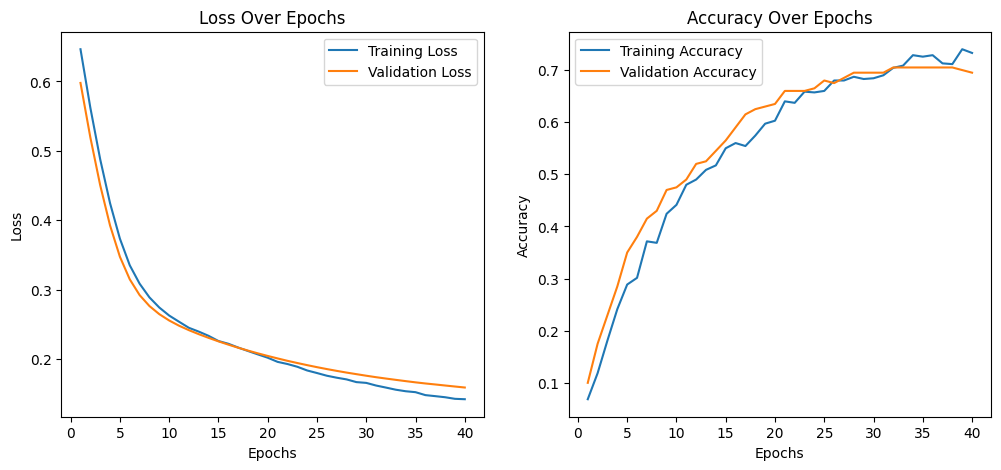

In [19]:
import matplotlib.pyplot as plt


train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs_range = range(1, len(train_loss) + 1)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")

plt.show()
